<a href="https://colab.research.google.com/github/Kobai/PokeType/blob/master/experiments/smol_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all the necessary packages

In [0]:
import urllib.request
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

## Download all the images from the pokémon website

In [0]:
os.mkdir('./imgs')
os.mkdir('./eval')
os.mkdir('./predict')
os.mkdir('./predict/imgs')

for i in range(649):
  num = '%03d' % (i+1)
  urllib.request.urlretrieve('https://assets.pokemon.com/assets/cms2/img/pokedex/full/%s.png' % num, './imgs/%s.png' % str(i+1))

for i in range(650,722):
  num = '%03d' % i
  urllib.request.urlretrieve('https://assets.pokemon.com/assets/cms2/img/pokedex/full/%s.png' % num, './eval/%s.png' % str(i))

## Move all the images to type based folders


In [0]:
# We use a csv from kaggle and index the pokemon image's id to find the appropriate type
df = pd.read_csv('pokemon_stat.csv')
train_list = df.head(649)['type_1'].to_list()
eval_list = df.head(721).tail(721-649)['type_1'].to_list()
all_types = list(set(train_list))

for ptype in all_types:
  os.mkdir('./imgs/%s' % ptype)

for ptype in all_types:
  os.mkdir('./eval/%s' % ptype)

for img in os.listdir('./imgs'):
  if re.match('\d+.png', img):
    index = int(img.split('.')[0])
    os.rename('./imgs/%s' % img, './imgs/%s/%s' % (train_list[index-1], img))

for img in os.listdir('./eval'):
  if re.match('\d+.png', img):
    index = int(img.split('.')[0])
    os.rename('./eval/%s' % img, './eval/%s/%s' % (eval_list[index-1-649], img))

## Prepare the data to be loaded into the model

In [0]:
# Transformations to apply to the train and test sets
train_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create datasets from the image folders and apply transformations
train_data = datasets.ImageFolder('imgs', transform=train_transform)
test_data = datasets.ImageFolder('eval', transform=test_transform)

# Create dataloaders from the datasets
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

## View some the images to see what the transformations look like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

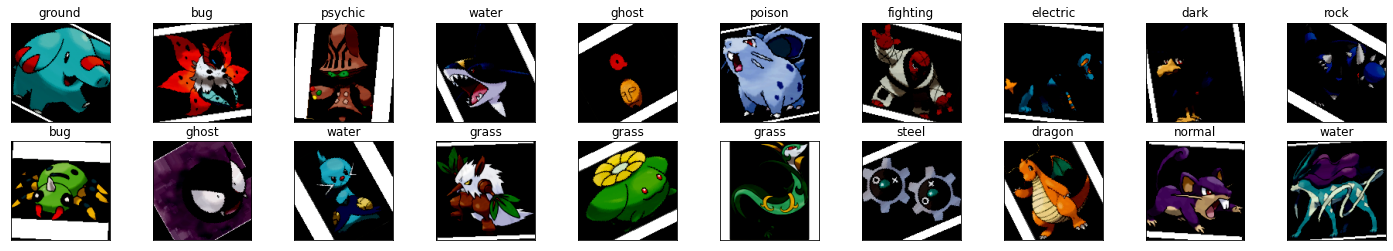

In [5]:
classes = ['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() 

img = plt.figure(figsize=(25, 4))
for i in range(20):
  ax = img.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[i], (1, 2, 0)))
  ax.set_title(classes[labels[i]])

In [6]:
images.shape

(32, 3, 128, 128)

## Define a CNN model

In [7]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 2, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 2, padding=1)
    self.conv3 = nn.Conv2d(64, 128, 2, padding=1)

    self.pool = nn.MaxPool2d(2,2)

    self.dropout = nn.Dropout(0.3)

    self.fc1 = nn.Linear(128 * 16 * 16, 512)
    self.fc2 = nn.Linear(512, 18)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 128 * 16 * 16)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = Net()
print(model)
model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=18, bias=True)
)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=18, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the model

In [9]:
model.train()
running_loss = 0.0

for epoch in range(30):
  for i, batch in enumerate(trainloader, 0):
    data, target = batch
    data, target = data.cuda(), target.cuda()

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 10 == 9:
      print(f'Epoch: {epoch+1} / Running Loss: {running_loss/10}')
      running_loss = 0.0

Epoch: 1 / Running Loss: 3.281173062324524
Epoch: 1 / Running Loss: 2.745350646972656
Epoch: 2 / Running Loss: 2.927502465248108
Epoch: 2 / Running Loss: 2.6484944343566896
Epoch: 3 / Running Loss: 2.8558274507522583
Epoch: 3 / Running Loss: 2.590634894371033
Epoch: 4 / Running Loss: 2.779468464851379
Epoch: 4 / Running Loss: 2.4915957927703856
Epoch: 5 / Running Loss: 2.62969856262207
Epoch: 5 / Running Loss: 2.445424222946167
Epoch: 6 / Running Loss: 2.555282640457153
Epoch: 6 / Running Loss: 2.2818962812423704
Epoch: 7 / Running Loss: 2.4546035528182983
Epoch: 7 / Running Loss: 2.258373522758484
Epoch: 8 / Running Loss: 2.325503778457642
Epoch: 8 / Running Loss: 2.161880600452423
Epoch: 9 / Running Loss: 2.303632748126984
Epoch: 9 / Running Loss: 2.0830480098724364
Epoch: 10 / Running Loss: 2.2997358322143553
Epoch: 10 / Running Loss: 1.9158388137817384
Epoch: 11 / Running Loss: 1.9131013035774231
Epoch: 11 / Running Loss: 1.8728139400482178
Epoch: 12 / Running Loss: 2.0152228832244

In [0]:
torch.save(model.state_dict(), 'poke_model.pt')

## Test the model

In [11]:
test_loss = 0.0
class_correct = list(0. for i in range(18))
class_total = list(0. for i in range(18))

with torch.no_grad():
  for data, target in testloader:
    data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(np.squeeze(correct_tensor.cpu().numpy()))

    for i in range(len(target.data)):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1

test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 5.568195



In [12]:
print(f'Accuracy: {100. * np.sum(class_correct) / np.sum(class_total)}%')

Accuracy: 27.77777777777778%
